**01_preprocessing_outputvariable_sampling**

- Created output variable datasets for ML (for filtering out the patients with masses)
- sampled test dataset that was set aside during modelling(for final validation)

used this container: 
ml:1.0

In [1]:
# load packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import math


from pandas_profiling import ProfileReport

from statistics import mean
import math
from scipy import stats

%matplotlib inline

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
base_dir = '/home/jovyan/work/Goldfinch/ML_paper/'
suffix = 'raw_data/intermediate_files/'
local_directory = '/home/jovyan/work/Goldfinch/Backup_computer/tuttle/S3/tuttle 2/clinical_tuttle_data'

In [3]:
df = pd.read_excel(f'{base_dir}raw_data/DKD_Abstracted_Data_v1.0_2021.04.27.xlsx', engine='openpyxl')
df_map = pd.read_csv(f'{base_dir}raw_data/Tuttle_source_GRE_id_mapping.csv')
df = pd.merge(df, df_map, left_on = "CURE-CKD Patient ID", right_on = "source_subject_id", how = 'inner')

# define some cleanup functions

In [4]:
# engineer the proportion of sclerosed glomeruli
def engineer_prop(row):
    if ((~math.isnan(row['prop_sclerosed'])) & (math.isnan(row['max_prop_sclerosed']))):
        return row['prop_sclerosed']   
    if ((math.isnan(row['prop_sclerosed'])) & (~math.isnan(row['max_prop_sclerosed']))):
        return row['max_prop_sclerosed']
    if ((math.isnan(row['prop_sclerosed'])) & (math.isnan(row['max_prop_sclerosed']))):
        return 0
    else:
        return mean([row['max_prop_sclerosed'],row['prop_sclerosed']])
    
# calculate disease subgroups
def engineer_ds(row):
    if ((row['Mixed Lesion of Diabetic Nephropathy Plus Other Diagnosis']) == 'Yes'):
        return 'mixed'   
    if ((row['Only Diabetic Nephropathy']) == 'Yes'):
        return 'DN'
    else:
        return 'other' 

# make a 'non white race' flag column    
def non_white_race(row):
    if ((row['Patient Ethnicity'] == 'Latino')):
        return True 
    if ((row['Patient Race'] != 'White')):
        return True 
    else:
        return False

# calculate duration of diabetes
def duration_dm(row):
    if ((row['dm_duration_edit']) == -1) & (row['dm_duration_text_edit'] == 'empty'):
        return 'Not Reported'   
    if ((row['dm_duration_edit']) == -1) & (row['dm_duration_text_edit'] != 'empty'):
        return row['dm_duration_text_edit']  
    if ((row['dm_duration_edit']) != -1) & (row['dm_duration_text_edit'] != 'empty'):
        return row['dm_duration_text_edit']   
    if (row['dm_duration_edit'] <= 5) & (row['dm_duration_edit'] > 0) & (row['dm_duration_text_edit'] == 'empty'):
        return '<5 years' 
    if (row['dm_duration_edit'] > 5) & (row['dm_duration_edit'] <= 10) & (row['dm_duration_text_edit'] == 'empty'):
        return '>5 years' 
    if (row['dm_duration_edit'] > 10) & (row['dm_duration_edit'] <= 20) & (row['dm_duration_text_edit'] == 'empty'):
        return '>10 years' 
    if (row['dm_duration_edit'] > 20):
        return '>20 years' 

# data cleaning to update the lab values

In [5]:
# make cleaning dictonary with new values
cleandict = {
 'Mesangial Expansion': 'Not Reported',
 'Mesangial Hypercellularity': 'Not Reported',
 'Nodular Sclerosis': 'Not Reported',
 'Global Glomerulosclerosis in >50%': 'Not Reported',
 'GBM Thickening': 'Not Available',
 'Podocytes Preserved': 'Not Reported',
 'Podocyte Hypertrophy': 'Not Reported',
 'Arteriosclerosis': 'Not Available',
 'Arteriolar Hyalinosis': 'Not Available',
 'TBM Thickening': 'Not Available',
 'Inflammatory Cell Infiltrate': 'Not Reported',
 'Fibrosis': 'Not Reported',
 'EM Done': 'Not Available',
 'Only Diabetic Nephropathy': 'Not Reported',
 'Mixed Lesion of Diabetic Nephropathy Plus Other Diagnosis': 'Not Reported',
}
df = df.fillna(value=cleandict)

df = df.replace({'Mesangial Expansion': {'Not Reported': 'No'}})
df = df.replace({'Mesangial Hypercellularity': {'Not Reported': 'No'}})
df = df.replace({'Nodular Sclerosis': {'Not Reported': 'No'}})
df = df.replace({'Global Glomerulosclerosis in >50%': {'Not Reported': 'No'}})

# replace the 'N' in Podcytes Preserved
df = df.replace({'Podocytes Preserved': {'N': 'No'}})

# make the patient column the index
df = df.set_index('CURE-CKD Patient ID')

# drop patients with masses
df = df[df['Biopsy Indication']!='Mass']

# calculate proportion of sclerosed glomeruli
df['max_prop_sclerosed'] = df['Maximal Number of Sclerosed Glomeruli per Section'] / df['Maximal Number of Glomeruli per Section']
df['prop_sclerosed'] = df['Total Number of Sclerosed Glomeruli'] / df['Total Number of Glomeruli']
df['prop_all_sclerosed'] = df.apply(lambda row: engineer_prop(row), axis=1)

# make new disease column with disease simple
df['disease_simple'] = df.apply(lambda row: engineer_ds(row), axis=1)

df['Adjusted Date of Biopsy'] = pd.to_datetime(df['Adjusted Date of Biopsy'], format='%Y-%m-%d %H:%M:%S')
df['adjusted_date_of_birth'] = pd.to_datetime(df['Adjusted Date-of-Birth'], format='%Y-%m-%d %H:%M:%S')

# calculate age
df['age_biopsy'] = df['Adjusted Date of Biopsy'] - df['Adjusted Date-of-Birth']
df['age_biopsy']=df['age_biopsy']/np.timedelta64(1,'Y')

#age at which diabetes develops 
df['diabetes_age'] = df['age_biopsy']-df['Duration of Diabetes at Time of Biopsy (years)']  

# calculate the duration of diabetes
df['dm_duration_edit'] = df['Duration of Diabetes at Time of Biopsy (years)'].fillna(value= -1)
df['dm_duration_text_edit'] = df['Duration of Diabetes at Time of Biopsy (range)'].fillna(value='empty')
df['duration_dm'] = df.apply(lambda row: duration_dm(row), axis=1)

#fill the NaNs in diabetic retinopathy
df = df.fillna(value={'Diabetic Retinopathy': 'Not Reported'})

# clustering
that was just for exploration, not actually used in modelling

number of columns/features
22
523
The proportion of variance explained of PC1 - PC14 are:
[0.24918894 0.15368121 0.0852553  0.08181863 0.067848   0.05975524
 0.05181148 0.0479815  0.03528407 0.03286936 0.02343744 0.02280039
 0.01893485 0.01480351]


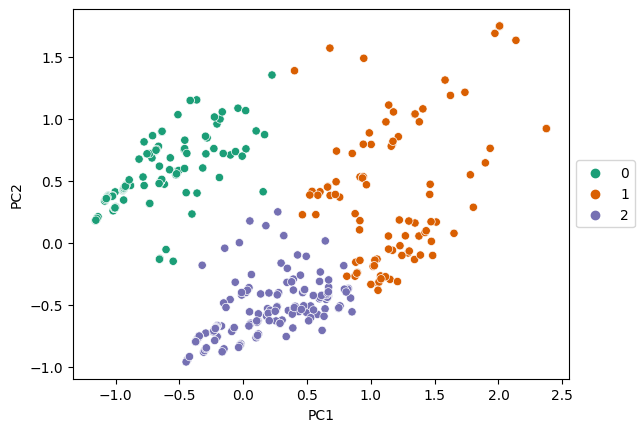

In [6]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

df_1hp = df[[
 'Mesangial Expansion',
 'Mesangial Hypercellularity',
 'Nodular Sclerosis',
 'Global Glomerulosclerosis in >50%',
 'GBM Thickening',
 'Podocytes Preserved',
 'Arteriosclerosis',
 'Arteriolar Hyalinosis',
 'TBM Thickening',
 'Inflammatory Cell Infiltrate',
 'Fibrosis',
 'disease_simple'  
]]

#drop lines that have all non reported

#make new variable to save that df
#df_1hp = df_1hp[(df_1hp == 'Not Reported').sum(1) < 12]
df_sclerosed = df_1hp.copy()

#select only the categorical columns
df_1hp = df_1hp[[
 'Mesangial Expansion',
 'Mesangial Hypercellularity',
 'Nodular Sclerosis',
 'Global Glomerulosclerosis in >50%',
 'GBM Thickening',
 'Podocytes Preserved',
 'Arteriosclerosis',
 'Arteriolar Hyalinosis',
 'TBM Thickening',
 'Inflammatory Cell Infiltrate',
 'Fibrosis',]]


enc = OneHotEncoder(drop='first').fit(df_1hp)
df_1h = enc.transform(df_1hp).toarray()

print('number of columns/features')
print(df_1h.shape[1])
print(len(df_1h))

# add proportion column
df_1h = np.append(df_1h, df['prop_all_sclerosed'].to_numpy()[...,None], 1)
df_1h.shape

# run PCA on the dataset first with 14
pca = PCA(n_components=23)
pca.fit(df_1h)
df_1h_prelim = pca.transform(df_1h)

pca = PCA(n_components=14)
pca.fit(df_1h)
df_1h = pca.transform(df_1h)

# convert into df
columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14']
df_1h = pd.DataFrame(df_1h, columns = columns)


# print how much variance are explained by PC0 and PC1 (first two components)
print('The proportion of variance explained of PC1 - PC14 are:') 
print(pca.explained_variance_ratio_)


kmean = KMeans(n_clusters=3)
X_kmean = kmean.fit(df_1h.iloc[:,:13])
y_pred = kmean.predict(df_1h.iloc[:,:13])

df_1h['k_means_3'] = y_pred

sns.scatterplot(data=df_1h, x="PC1", y="PC2", hue="k_means_3", palette = 'Dark2')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [7]:
df_out = df[['disease_simple',
             'TBM Thickening',
             'GBM Thickening',
             'Inflammatory Cell Infiltrate',
             'Nodular Sclerosis',
             'Mesangial Hypercellularity',
             'Arteriolar Hyalinosis',
             'source_subject_id',
             'gfb_subject_id',
             'age_biopsy',
             'diabetes_age',
             'duration_dm',
             'Diabetic Retinopathy', 
            ]]
                 
# just do boolean classification 
df_out['is_DN'] = df_out["disease_simple"] == 'DN'
df_out['k_means'] = y_pred
df_out['k_means_binary'] = df_out['k_means'] == 0
df_out['TBM Thickening'] = df_out["TBM Thickening"] == 'Yes'
df_out['GBM Thickening'] = df_out["GBM Thickening"] == 'Yes'
df_out['Nodular Sclerosis'] = df_out["Nodular Sclerosis"] == 'Yes'
df_out['Inflammatory Cell Infiltrate'] = df_out["Inflammatory Cell Infiltrate"] == 'Yes'
df_out['Mesangial Hypercellularity'] = df_out["Mesangial Hypercellularity"] == 'Yes'
df_out['Arteriolar Hyalinosis'] = df_out["Arteriolar Hyalinosis"] == 'Yes'

df_out = df_out.replace({'disease_simple': {'DN': 1, 'mixed': 2, 'other': 3}})

# rename columns
existing_col_list = list(df_out.columns)
new_col_list = [str(x).replace("-", "_").replace(">", "gt").replace("<", "lt").replace("/", "_per_").replace("%", "pcnt").replace(" ", "_").replace("(", "").replace(")", "") for x in existing_col_list]
df_out.columns = new_col_list

/tmp/ipykernel_146/2034827686.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['is_DN'] = df_out["disease_simple"] == 'DN'
/tmp/ipykernel_146/2034827686.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['k_means'] = y_pred
/tmp/ipykernel_146/2034827686.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [8]:
df.head()

,Adjusted Date-of-Birth,Patient Gender,Patient Race,Patient Ethnicity,Diabetes State,Diabetic Retinopathy,Duration of Diabetes at Time of Biopsy (years),Duration of Diabetes at Time of Biopsy (range),Adjusted Date of Biopsy,Biopsy Indication,...,max_prop_sclerosed,prop_sclerosed,prop_all_sclerosed,disease_simple,adjusted_date_of_birth,age_biopsy,diabetes_age,dm_duration_edit,dm_duration_text_edit,duration_dm
CURE-CKD Patient ID,,,,,,,,,,,,,,,,,,,,,
5404,1958-06-03,Female,Asian,Non-Latino,Type 2,Not Reported,22.0,NaN,2015-08-16,Proteinuria,...,0.217391,NaN,0.217391,mixed,1958-06-03,57.203091,35.203091,22.0,empty,>20 years
8107,1962-03-18,Male,White,Latino,Type 2,Not Reported,NaN,NaN,2015-03-01,AKI,...,0.100000,NaN,0.100000,other,1962-03-18,52.953859,NaN,-1.0,empty,Not Reported
8332,1957-09-09,Male,American Indian or Alaska Native,Non-Latino,Type 2,Not Reported,NaN,>5 years,2015-12-14,Proteinuria,...,0.666667,NaN,0.666667,other,1957-09-09,58.262661,NaN,-1.0,>5 years,>5 years
9991,1961-01-18,Female,White,Non-Latino,No Diabetes Indicated,No,NaN,NaN,2015-05-08,Other,...,0.250000,NaN,0.250000,other,1961-01-18,54.300910,NaN,-1.0,empty,Not Reported
12321,1963-09-23,Female,White,Non-Latino,Type 2,Not Reported,6.0,NaN,2017-02-04,Other,...,0.645161,NaN,0.645161,other,1963-09-23,53.370021,47.370021,6.0,empty,>5 years


In [9]:
df.columns.tolist()

['Adjusted Date-of-Birth',
 'Patient Gender',
 'Patient Race',
 'Patient Ethnicity',
 'Diabetes State',
 'Diabetic Retinopathy',
 'Duration of Diabetes at Time of Biopsy (years)',
 'Duration of Diabetes at Time of Biopsy (range)',
 'Adjusted Date of Biopsy',
 'Biopsy Indication',
 'Description of Other Biopsy Indication',
 'Adjusted Date of Last Serum Creatinine Measure Closest to Biopsy',
 'Serum Creatinine (mg/dL) Value',
 'Adjusted Date of Last UACR Measure Closest to Biopsy',
 'UACR (mg/g) Value',
 'Adjusted Date of Last UPCR Measure Closest to Biopsy',
 'UPCR (g/g) Value',
 'Adjusted Date of Last 24 Hour Urine Protein Measure Closest to Biopsy',
 '24 Hour Urine Protein (mg) Value',
 'Total Number of Glomeruli',
 'Total Number of Sclerosed Glomeruli',
 'Maximal Number of Glomeruli per Section',
 'Maximal Number of Sclerosed Glomeruli per Section',
 'Mesangial Expansion',
 'Mesangial Hypercellularity',
 'Nodular Sclerosis',
 'Global Glomerulosclerosis in >50%',
 'GBM Thickening',
 '

# actual sampling of patients for test dataset

In [10]:
# merge with dem dataframe to get the state annotation

   
dem_df = pd.read_csv(f'{base_dir}raw_data/athena_data/demographics/gfb_demographics.csv', sep = '|')
dem_df = dem_df[['patient_id', 'state']]

df_out = pd.merge(dem_df, df_out, left_on = 'patient_id', right_on = 'CURE-CKD Patient ID', how = 'right')

In [11]:
# create test dataframe
df_sample = df_out.sample(frac=0.15, replace=False, random_state=6)
sample_pt_list = df_sample['gfb_subject_id'].tolist()

# create the training and validation dataframe
boolean_series = df_out['gfb_subject_id'].isin(sample_pt_list)
filtered_df = df_out[~boolean_series]

print(len(df_out))
print(len(filtered_df))
print(len(df_sample))

print('proportion of OR')
print(len(df_out[df_out['state'] == 'OR'])/len(df_out))
print(len(filtered_df[filtered_df['state'] == 'OR'])/len(filtered_df))
print(len(df_sample[df_sample['state'] == 'OR'])/len(df_sample))

523
445
78
proportion of OR
0.12045889101338432
0.12134831460674157
0.11538461538461539


In [12]:
flist = df_sample.columns.tolist()

for item in flist:
    print(item)
    print(df_sample[item].value_counts())

patient_id
589152     1
183535     1
87173      1
2213230    1
2437121    1
          ..
2137664    1
2427623    1
404758     1
1727050    1
1058812    1
Name: patient_id, Length: 78, dtype: int64
state
WA    40
CA    20
OR     9
AK     5
MT     2
IA     1
ID     1
Name: state, dtype: int64
disease_simple
2    28
3    25
1    25
Name: disease_simple, dtype: int64
TBM_Thickening
False    58
True     20
Name: TBM_Thickening, dtype: int64
GBM_Thickening
True     56
False    22
Name: GBM_Thickening, dtype: int64
Inflammatory_Cell_Infiltrate
True     59
False    19
Name: Inflammatory_Cell_Infiltrate, dtype: int64
Nodular_Sclerosis
True     42
False    36
Name: Nodular_Sclerosis, dtype: int64
Mesangial_Hypercellularity
False    61
True     17
Name: Mesangial_Hypercellularity, dtype: int64
Arteriolar_Hyalinosis
True     51
False    27
Name: Arteriolar_Hyalinosis, dtype: int64
source_subject_id
589152     1
183535     1
87173      1
2213230    1
2437121    1
          ..
2137664    1
2427623  

In [13]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 0 to 522
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    523 non-null    int64  
 1   state                         523 non-null    object 
 2   disease_simple                523 non-null    int64  
 3   TBM_Thickening                523 non-null    bool   
 4   GBM_Thickening                523 non-null    bool   
 5   Inflammatory_Cell_Infiltrate  523 non-null    bool   
 6   Nodular_Sclerosis             523 non-null    bool   
 7   Mesangial_Hypercellularity    523 non-null    bool   
 8   Arteriolar_Hyalinosis         523 non-null    bool   
 9   source_subject_id             523 non-null    int64  
 10  gfb_subject_id                523 non-null    object 
 11  age_biopsy                    523 non-null    float64
 12  diabetes_age                  330 non-null    float64
 13  durat

In [14]:
# save to local drive
df_sample.to_csv(f'{base_dir}{suffix}ML_target_variables_test.csv' , index=False, header=True)
filtered_df.to_csv(f'{base_dir}{suffix}ML_target_variables_trainval.csv' , index=False, header=True)